# 年齢欠損を似た属性の中央値で補完する


In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

sys.path.append(os.path.join(os.path.dirname('__file__'), "../"))


warnings.filterwarnings('ignore')


sns.set(style='white', context='notebook', palette='deep')
%matplotlib inline

In [2]:
train = pd.read_csv('../input_data/train.csv')
test = pd.read_csv('../input_data/test.csv')

data = pd.concat([train, test]).copy()
data = data[['Survived', 'Age', 'Sex', 'Pclass', 'SibSp', 'Parch']] # 対象を一気に絞っておく

# 年齢と生存率の関係

## 年齢と生存率を比較する

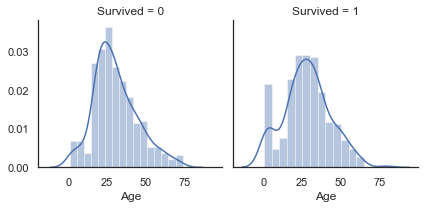

In [3]:
g = sns.FacetGrid(train, col='Survived')

g = g.map(sns.distplot, 'Age')

### 考察
- 分布は正規分布っぽい
- 2つの分布は別物であることに注意ね
    - Suvived=0: 尖っている
    - Suvived=1: 裾野が広い ≒ 赤ちゃんや高齢者は生存しやすい(ピークもある)
- 連続量としての年齢のというより、年齢のカテゴリ が 生存率に影響していそうな感じがある

## 分布の違いを比較する: 2つの分布を重ねて表示

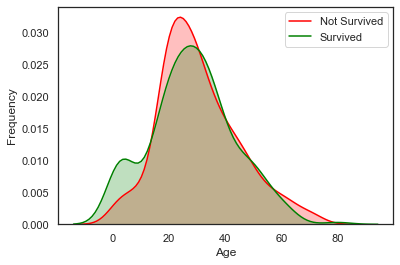

In [4]:
sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())],
            color='Red',
            shade=True)

sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())],
            color='Green',
            shade=True)


plt.xlabel('Age')
plt.ylabel('Frequency')

plt.legend(['Not Survived', 'Survived'])

# Ageの欠損対応
- Ageの欠損値は全体で 263個 あった

## 方針: 既知の変数から年齢を予測する
- Ageと関係が深そうな、Sex, Parch , Pclass and SibSP を利用する
- ここからはtrainとtestをあわせたdataで分析する


## 年齢と性別

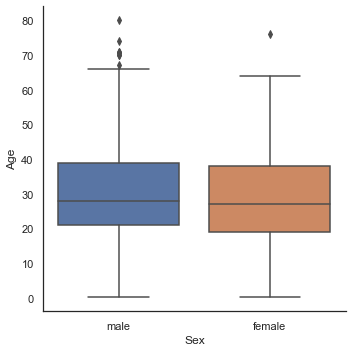

In [5]:
sns.factorplot(y="Age",
               x="Sex",
               data=data,
               kind="box")

### 考察
- 年齢の分布は男女で大きな差はなさそう → 性別からの年齢予測は難しそうだ

## 年齢とPclass

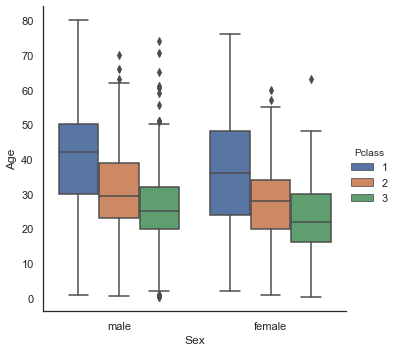

In [6]:
sns.factorplot(y="Age",
               x="Sex",
               hue="Pclass",
               data=data,
               kind="box")

### 考察
- Pclassのグレードが高いほど年齢が高い傾向がある

## 年齢とParch

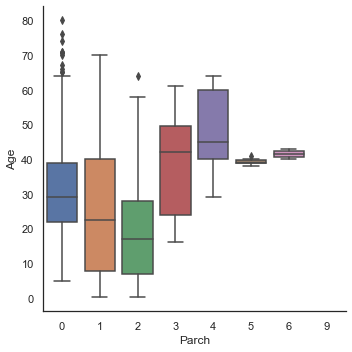

In [7]:
sns.factorplot(y="Age",
               x="Parch",
               data=data,
               kind="box")

### 考察
- より多くの乗客が両親/子供を持っているほどより年上

## 年齢とSibSp

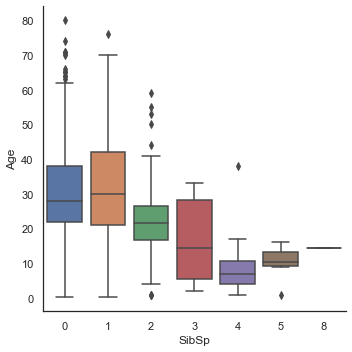

In [8]:
sns.factorplot(y="Age",
               x="SibSp",
               data=data,
               kind="box")

### 考察
- より多くの同乗者は兄弟/配偶者を持っているとより若い

## 年齢と各変数の相関を見る

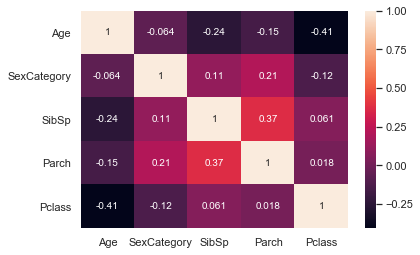

In [9]:
# 性別をカテゴリカルデータに変換
data['SexCategory'] = data['Sex'].map({'male': 0, 'female': 1})

g = sns.heatmap(data[['Age', 'SexCategory', 'SibSp', 'Parch', 'Pclass']].corr(),
                annot=True)

### 解釈
####  ざっくり
- Sex: 相関はほぼない(性別からの年齢予測はやはり無理そう)
- SibSp: 負の相関
- Parch: 負の相関; plotでは正の相関(右肩上り)にも見えたが、全体では負の相関
- Pclass: 負の相関; 他の変数より強い相関

#### で、どうするか？
- SibSp, Parch, Pclass を使って Age の補完をやってみよう
    - SibSp, Parch, Pclass が似ているデータの中央値を使う作戦

# いざ、補完をしてみる
## 方針
1. ['Pclass', 'SibSp', 'Parch']の組み合わせごとに、年齢の中央値を計算する
2. 組み合わせに応じて補完する
3. 存在しないパターンの場合は、全体の中央値で補完する

## 補完作業

In [10]:
# 'Pclass', 'SibSp', 'Parch' で年齢の中央値を計算しておく
age_from_personal_data =  data.copy().groupby(['Pclass', 'SibSp', 'Parch']).median()[['Age']].reset_index()

age_from_personal_data.head()

,Pclass,SibSp,Parch,Age
0,1,0,0,39.0
1,1,0,1,37.5
2,1,0,2,22.0
3,1,1,0,38.0
4,1,1,1,49.0


In [11]:
# TODO: Refactor
age_median = data['Age'].median()

imputation_age_list = []

for idx, row in tqdm(data[['Age', 'SibSp', 'Parch', 'Pclass']].iterrows()):
    age, sibsp, parch, pclass = row[0], row[1], row[2], row[3]

    if not np.isnan(age):
        imputation_age_list.append(age)
    else:
        age_pred = age_from_personal_data['Age'][(age_from_personal_data['SibSp'] == sibsp)
                                                 & (age_from_personal_data['Parch'] == parch)
                                                 & (age_from_personal_data['Pclass'] == pclass)].median()

        if np.isnan(age_pred):
            # 存在しないパターンなら中央値
            imputation_age_list.append(age_median)
        else:
            imputation_age_list.append(age_pred)

data['FilledAgeFromPerson'] = imputation_age_list

## 補完後の分布を確認する

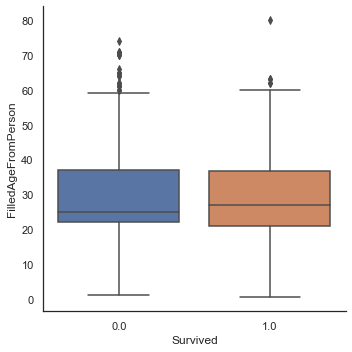

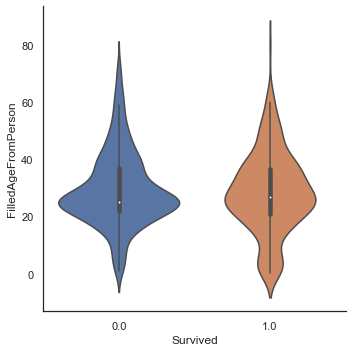

In [12]:
sns.factorplot(x="Survived", y="FilledAgeFromPerson", data=data, kind="box")
sns.factorplot(x="Survived", y="FilledAgeFromPerson", data=data, kind="violin")

### 考察
- 生存死亡に関係なく中央値は同じくらいになっている
- 生き残った乗客のバイオリンプロットをみると、非常に若い乗客の方が生存率が高いことがわかる